In [1]:
!nvidia-smi

Sun May 28 09:31:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    43W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q --upgrade transformers diffusers ftfy huggingface_hub
!pip install -q accelerate
!pip install -q datasets
!pip install -q open_clip_torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 106.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 113.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 76.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [24]:
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms as tfms
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, DPMSolverMultistepScheduler, LMSDiscreteScheduler, StableDiffusionInpaintPipeline
from tqdm.auto import tqdm
import os
import cv2
from base64 import b64encode
import numpy as np 
from IPython.display import HTML
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
import random
import matplotlib.pyplot as plt

In [4]:
inpaint = StableDiffusionInpaintPipeline.from_pretrained("stabilityai/stable-diffusion-2-inpainting",
                                                         revision="fp16",torch_dtype=torch.float16)

unet/diffusion_pytorch_model.safetensors not found


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [5]:
unet = UNet2DConditionModel.from_config(inpaint.unet.config)
print(f'unet.config.in_channels : {unet.config.in_channels}, unet.config.out_channels : {unet.config.out_channels}')

unet.config.in_channels : 9, unet.config.out_channels : 4


In [6]:
state_dict = inpaint.unet.state_dict()
unet.load_state_dict(state_dict)

<All keys matched successfully>

In [7]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse")
tokenizer = CLIPTokenizer.from_pretrained("stabilityai/stable-diffusion-2-1", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("stabilityai/stable-diffusion-2-1", subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained("stabilityai/stable-diffusion-2-inpainting", subfolder="unet")
scheduler = DPMSolverMultistepScheduler.from_pretrained("stabilityai/stable-diffusion-2-1", subfolder="scheduler")

In [8]:
unet.config

FrozenDict([('sample_size', 64),
            ('in_channels', 9),
            ('out_channels', 4),
            ('center_input_sample', False),
            ('flip_sin_to_cos', True),
            ('freq_shift', 0),
            ('down_block_types',
             ['CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'DownBlock2D']),
            ('mid_block_type', 'UNetMidBlock2DCrossAttn'),
            ('up_block_types',
             ['UpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D']),
            ('only_cross_attention', False),
            ('block_out_channels', [320, 640, 1280, 1280]),
            ('layers_per_block', 2),
            ('downsample_padding', 1),
            ('mid_block_scale_factor', 1),
            ('act_fn', 'silu'),
            ('norm_num_groups', 32),
            ('norm_eps', 1e-05),
            ('cross_attention_dim', 1024),
            ('

In [9]:
scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.00085),
            ('beta_end', 0.012),
            ('beta_schedule', 'scaled_linear'),
            ('trained_betas', None),
            ('solver_order', 2),
            ('prediction_type', 'v_prediction'),
            ('thresholding', False),
            ('dynamic_thresholding_ratio', 0.995),
            ('sample_max_value', 1.0),
            ('algorithm_type', 'dpmsolver++'),
            ('solver_type', 'midpoint'),
            ('lower_order_final', True),
            ('use_karras_sigmas', False),
            ('_class_name', 'DDIMScheduler'),
            ('_diffusers_version', '0.8.0'),
            ('clip_sample', False),
            ('set_alpha_to_one', False),
            ('skip_prk_steps', True),
            ('steps_offset', 1)])

In [10]:
vae.to(device)
text_encoder.to(device)
unet.to(device)
print(f'Moved vae, text_encoder , unet to {device}')

Moved vae, text_encoder , unet to cuda


In [11]:
vae.config.scaling_factor, scheduler.init_noise_sigma

(0.18215, 1.0)

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [13]:
!cp -r '/content/gdrive/MyDrive/EVA8_P1_S15/inpaint_eval_images_new' '.'
!cp -r '/content/gdrive/MyDrive/EVA8_P1_S15/inpaint_eval_images_new2' '.'

In [14]:
inf_steps = 50
t1 = scheduler.set_timesteps(inf_steps)
print(scheduler.timesteps)
print(scheduler.timesteps[:3])

tensor([999, 979, 959, 939, 919, 899, 879, 859, 839, 819, 799, 779, 759, 739,
        719, 699, 679, 659, 639, 619, 599, 579, 559, 539, 519, 500, 480, 460,
        440, 420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180,
        160, 140, 120, 100,  80,  60,  40,  20])
tensor([999, 979, 959])


In [15]:
attempt_dict = {"Attempt4A": [{"infer_steps": 10, "noise_reduce_item" :"OI-MI-BM", "noise_pred_item" : "OI-MI-BM"}],
                "Attempt4B": [{"infer_steps": 30, "noise_reduce_item" :"OI-MI-BM", "noise_pred_item" : "OI-MI-BM"}],
                "Attempt4C": [{"infer_steps": 10, "noise_reduce_item" :"MI-BM",    "noise_pred_item" : "OI-MI-BM"}],
                "Attempt4D": [{"infer_steps": 30, "noise_reduce_item" :"MI-BM",    "noise_pred_item" : "OI-MI-BM"}],
                "Attempt4E": [{"infer_steps": 10, "noise_reduce_item" :"OI-BM",    "noise_pred_item" : "OI-MI-BM"}],
                "Attempt4F": [{"infer_steps": 30, "noise_reduce_item" :"OI-BM",    "noise_pred_item" : "OI-MI-BM"}],
                "Attempt4G": [{"infer_steps": 50, "noise_reduce_item" :"MI",       "noise_pred_item" : "OI-MI-BM"}],
                "Attempt4H": [{"infer_steps": 30, "noise_reduce_item" :"MI",       "noise_pred_item" : "OI-MI-BM"}],
                "Attempt4I": [{"infer_steps": 10, "noise_reduce_item" :"MI",       "noise_pred_item" : "OI-MI-BM"}],
                "Attempt4J": [{"infer_steps": 50, "noise_reduce_item" :"OI",       "noise_pred_item" : "OI-MI-BM"}],
                "Attempt4K": [{"infer_steps": 30, "noise_reduce_item" :"OI",       "noise_pred_item" : "OI-MI-BM"}],
                "Attempt4L": [{"infer_steps": 10, "noise_reduce_item" :"OI",       "noise_pred_item" : "OI-MI-BM"}]}

In [16]:
# let's seperate out the functions
batch_size = 1

image_transforms = tfms.Compose([
    tfms.Resize((512, 512)),
    tfms.ToTensor()
])

def perturb_latents(latents, threshold = 0.01):
    latents[latents < threshold] = 255
    return (latents - latents.mean()) / latents.std()

def create_vae_latents(orig_img, masked_img, mask):
    orig_img_pil      = Image.open(orig_img).resize((512, 512)) 
    masked_img_pil    = Image.open(masked_img).resize((512, 512))
    mask_pil          = Image.open(mask)  
    mask_pil_tensor   = image_transforms(mask_pil).unsqueeze(0)

    orig_img_latent   = encode_image_to_latents(orig_img_pil)
    masked_img_latent = encode_image_to_latents(masked_img_pil)
    masks_ht_width    = [orig_img_latent.shape[-2], orig_img_latent.shape[-1]]
    mask_latent       = torch.nn.functional.interpolate(mask_pil_tensor, size=masks_ht_width)

    return orig_img_latent, masked_img_latent, mask_latent

In [17]:
def get_text_embeddings(prompt):
    text_input = tokenizer(
        prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
    )

    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])   # Shape is [b, 77, 1024]

    return text_embeddings

In [20]:
def create_input_latents(noise_reduce_items, noise_pred_items):
    if noise_reduce_items == "OI-MI-BM":
        in_latent = torch.cat([orig_img_latent, masked_img_latent, mask_latent], dim=1)
        reduce_latent = conv1d_9_4(in_latent)
    elif noise_reduce_items == "MI-BM":
        in_latent = torch.cat([masked_img_latent, mask_latent], dim=1)  
        reduce_latent = conv1d_5_4(in_latent)         
    elif noise_reduce_items == "OI-BM":
        in_latent = torch.cat([orig_img_latent, mask_latent], dim=1)    
        conv1d = conv1d_5_4.to(device)
        reduce_latent = conv1d(in_latent)          
    elif noise_reduce_items =="MI":
        reduce_latent = masked_img_latent
    elif noise_reduce_items == "OI":
        reduce_latent = orig_img_latent

    if noise_pred_items == "OI-MI-BM":
        pred_latent = torch.cat([orig_img_latent, masked_img_latent, mask_latent], dim=1)
  
    
    return reduce_latent, pred_latent

In [48]:
def get_unet_latents(attempt_key, orig_img_latent, masked_img_latent, mask_latent, 
                     text_embeddings, height=512, width=512, num_inference_steps=50,
                guidance_scale=7.5, latents=None, seed=0,
                return_all_latents=False):  
    
    generator = torch.manual_seed(seed)
    batch_size = text_embeddings.shape[0]//2

    attempt_rec = attempt_dict[attempt_key]
    print(f'Attempt : {attempt_rec}')
    noise_reduce_items = attempt_rec[0]["noise_reduce_item"]
    noise_pred_items = attempt_rec[0]["noise_pred_item"]
    

    reduce_latent, unet_latent = create_input_latents(noise_reduce_items, noise_pred_items)

    input_latent = unet_latent

    if latents == None:
        input_latent = torch.randn(
            batch_size, unet.config.in_channels, height//8, width//8,
            generator=generator
        )

    #all_latents
    all_latents = [input_latent]

    scheduler.set_timesteps(num_inference_steps)

    # Setting latents to masked_img_latent. When t = 999, ie when the loop runs for first time, 
    # noise will be reduced from the vae latent corresponding to the masked image via below code
    # latents = scheduler.step(noise_pred, t, latents).prev_sample 
    latents = reduce_latent

    #latents = perturb_latents(masked_img_latent, thresh_value)
    
    infer_steps = attempt_rec[0]["infer_steps"]
    print(f'Infer steps : {scheduler.timesteps[:infer_steps]}')
    for t in tqdm(scheduler.timesteps[:infer_steps]):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([input_latent] * 2)

        latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t.to(dtype=torch.float32), encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample
        all_latents.append(input_latent)

    if not return_all_latents:
        return latents
    
    all_latents = torch.cat(all_latents, dim=0)

    return all_latents

In [22]:
def encode_image_to_latents(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]

    img_arr = np.stack([np.array(img) for img in imgs], axis = 0)
    img_arr = img_arr / 255.0
    img_arr = torch.from_numpy(img_arr).float().permute(0, 3, 1, 2)
    img_arr = 2 * (img_arr - 0.5)

    latent_dists = vae.encode(img_arr.to(device)).latent_dist.sample()
    latent_samples = latent_dists
    latent_samples *= vae.config.scaling_factor

    return latent_samples

def decode_latents_to_img(latents):
    latents = 1 / vae.config.scaling_factor * latents
    with torch.no_grad():
        image = vae.decode(latents).sample

    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()    
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [36]:
def prompt_to_img(orig_img_latent, 
                  masked_img_latent, 
                  mask_latent, 
                  text_embeddings,
                  attempt_key = "",
                  orig_img="",
                  masked_img="",
                  mask="",
                  _prompt = "",
                  height = 512,  # default height of Stable Diffusion
                  width = 512,  # default width of Stable Diffusion
                  num_inference_steps = 50,  # Number of denoising steps
                  guidance_scale = 15,  # Scale for classifier-free guidance
                  seed = 0,  # Seed generator to create the inital latent noise
                  return_all_latents = False,
                  batch_size = 2,
                  latents = True
                  ):

    latents = get_unet_latents(attempt_key,
                               orig_img_latent,
                               masked_img_latent,
                               mask_latent,
                                text_embeddings, 
                                height=height, 
                                width=width, 
                                num_inference_steps=num_inference_steps,
                                guidance_scale=guidance_scale, 
                                latents=latents,
                                seed=seed,
                                return_all_latents=return_all_latents)
    all_imgs = []
    for i in tqdm(range(0, len(latents), batch_size)):
        imgs = decode_latents_to_img(latents[i:i+batch_size])
        all_imgs.extend(imgs)

    return all_imgs

In [26]:
def show_images(orig_img_resize, masked_img_resize, mask_img_resize, pred_img):
    pred_img_resize = pred_img.resize((128, 128))
    fig, axs = plt.subplots(1, 4)

    # Display the resized RGB images
    axs[0].imshow(orig_img_resize)
    axs[0].axis('off')

    axs[1].imshow(masked_img_resize)
    axs[1].axis('off')

    # Display the resized grayscale image
    axs[2].imshow(mask_img_resize, cmap='gray')
    axs[2].axis('off')

    axs[3].imshow(pred_img_resize)
    axs[3].axis('off')

    # Adjust the layout and display the grid of images
    plt.tight_layout()
    plt.show()

In [27]:
orig_img_ip   = '/content/inpaint_eval_images_new/fb2.jpg'
masked_img_ip = '/content/inpaint_eval_images_new/fb2_mod.jpg'
mask_ip       = '/content/inpaint_eval_images_new/fb2_mask.jpg'
prompt_ip     = "Same Background"

orig_img_pil = Image.open(orig_img_ip)
masked_img_pil = Image.open(masked_img_ip)
mask_img_pil = Image.open(mask_ip).convert('L')

orig_img_resize = orig_img_pil.resize((128, 128))
masked_img_resize = masked_img_pil.resize((128, 128))
mask_img_resize = mask_img_pil.resize((128, 128))

print(orig_img_resize.size, masked_img_resize.size, mask_img_resize.size)

(128, 128) (128, 128) (128, 128)


In [28]:
orig_img_latent, masked_img_latent, mask_latent = create_vae_latents(orig_img   = orig_img_ip,
                                                                     masked_img = masked_img_ip,
                                                                     mask       = mask_ip)
text_embeddings = get_text_embeddings(prompt_ip)

orig_img_latent   = orig_img_latent.to(device)
masked_img_latent = masked_img_latent.to(device)
mask_latent       = mask_latent.to(device)    

orig_img_latent   = orig_img_latent * scheduler.init_noise_sigma
masked_img_latent = masked_img_latent * scheduler.init_noise_sigma
mask_latent       = mask_latent * scheduler.init_noise_sigma

conv1d_9_4 = nn.Conv2d(9, 4, kernel_size=1)
conv1d_9_4 = conv1d_9_4.to(device)

conv1d_5_4 = nn.Conv2d(5, 4, kernel_size=1)
conv1d_5_4 = conv1d_5_4.to(device)

###Attempt4A

In [49]:
pred_img = prompt_to_img(orig_img_latent, 
                         masked_img_latent, 
                         mask_latent, 
                         text_embeddings,
                         attempt_key = "Attempt4A",
                         orig_img   = orig_img_ip,
                         masked_img = masked_img_ip,
                         mask       = mask_ip ,
                         _prompt    = prompt_ip, 
                         num_inference_steps = 50, 
                         return_all_latents=False, seed=42)[-1]

Attempt : [{'infer_steps': 10, 'noise_reduce_item': 'OI-MI-BM', 'noise_pred_item': 'OI-MI-BM'}]
Infer steps : tensor([999, 979, 959, 939, 919, 899, 879, 859, 839, 819])


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

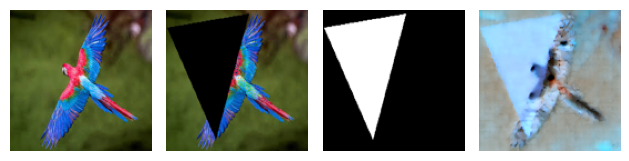

In [50]:
show_images(orig_img_resize, masked_img_resize, mask_img_resize, pred_img)

###Attempt4B

Attempt : [{'infer_steps': 30, 'noise_reduce_item': 'OI-MI-BM', 'noise_pred_item': 'OI-MI-BM'}]
Infer steps : tensor([999, 979, 959, 939, 919, 899, 879, 859, 839, 819, 799, 779, 759, 739,
        719, 699, 679, 659, 639, 619, 599, 579, 559, 539, 519, 500, 480, 460,
        440, 420])


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

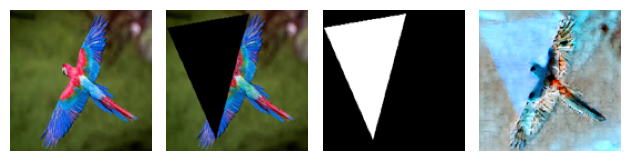

In [52]:
pred_img = prompt_to_img(orig_img_latent, 
                         masked_img_latent, 
                         mask_latent, 
                         text_embeddings,
                         attempt_key = "Attempt4B",
                         orig_img   = orig_img_ip,
                         masked_img = masked_img_ip,
                         mask       = mask_ip ,
                         _prompt    = prompt_ip, 
                         num_inference_steps = 50, 
                         return_all_latents=False, seed=42)[-1]

show_images(orig_img_resize, masked_img_resize, mask_img_resize, pred_img)

###Attempt4C

Attempt : [{'infer_steps': 10, 'noise_reduce_item': 'MI-BM', 'noise_pred_item': 'OI-MI-BM'}]
Infer steps : tensor([999, 979, 959, 939, 919, 899, 879, 859, 839, 819])


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

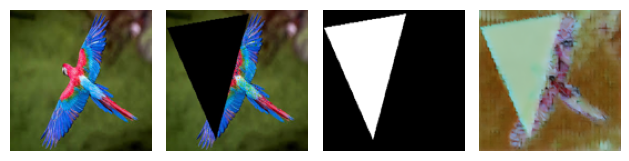

In [53]:
pred_img = prompt_to_img(orig_img_latent, 
                         masked_img_latent, 
                         mask_latent, 
                         text_embeddings,
                         attempt_key = "Attempt4C",
                         orig_img   = orig_img_ip,
                         masked_img = masked_img_ip,
                         mask       = mask_ip ,
                         _prompt    = prompt_ip, 
                         num_inference_steps = 50, 
                         return_all_latents=False, seed=42)[-1]

show_images(orig_img_resize, masked_img_resize, mask_img_resize, pred_img)

###Attempt4D

Attempt : [{'infer_steps': 30, 'noise_reduce_item': 'MI-BM', 'noise_pred_item': 'OI-MI-BM'}]
Infer steps : tensor([999, 979, 959, 939, 919, 899, 879, 859, 839, 819, 799, 779, 759, 739,
        719, 699, 679, 659, 639, 619, 599, 579, 559, 539, 519, 500, 480, 460,
        440, 420])


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

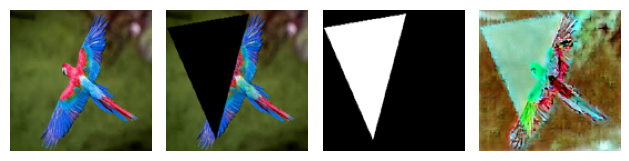

In [54]:
pred_img = prompt_to_img(orig_img_latent, 
                         masked_img_latent, 
                         mask_latent, 
                         text_embeddings,
                         attempt_key = "Attempt4D",
                         orig_img   = orig_img_ip,
                         masked_img = masked_img_ip,
                         mask       = mask_ip ,
                         _prompt    = prompt_ip, 
                         num_inference_steps = 50, 
                         return_all_latents=False, seed=42)[-1]

show_images(orig_img_resize, masked_img_resize, mask_img_resize, pred_img)

###Attempt4E

Attempt : [{'infer_steps': 10, 'noise_reduce_item': 'OI-BM', 'noise_pred_item': 'OI-MI-BM'}]
Infer steps : tensor([999, 979, 959, 939, 919, 899, 879, 859, 839, 819])


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

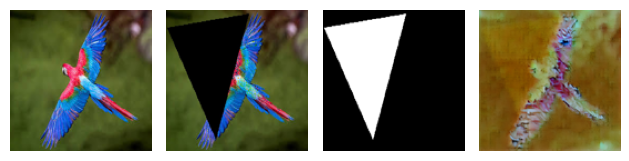

In [55]:
pred_img = prompt_to_img(orig_img_latent, 
                         masked_img_latent, 
                         mask_latent, 
                         text_embeddings,
                         attempt_key = "Attempt4E",
                         orig_img   = orig_img_ip,
                         masked_img = masked_img_ip,
                         mask       = mask_ip ,
                         _prompt    = prompt_ip, 
                         num_inference_steps = 50, 
                         return_all_latents=False, seed=42)[-1]

show_images(orig_img_resize, masked_img_resize, mask_img_resize, pred_img)

###Attempt4F

Attempt : [{'infer_steps': 30, 'noise_reduce_item': 'OI-BM', 'noise_pred_item': 'OI-MI-BM'}]
Infer steps : tensor([999, 979, 959, 939, 919, 899, 879, 859, 839, 819, 799, 779, 759, 739,
        719, 699, 679, 659, 639, 619, 599, 579, 559, 539, 519, 500, 480, 460,
        440, 420])


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

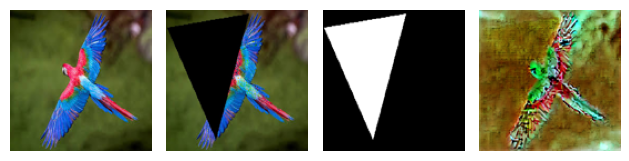

In [56]:
pred_img = prompt_to_img(orig_img_latent, 
                         masked_img_latent, 
                         mask_latent, 
                         text_embeddings,
                         attempt_key = "Attempt4F",
                         orig_img   = orig_img_ip,
                         masked_img = masked_img_ip,
                         mask       = mask_ip ,
                         _prompt    = prompt_ip, 
                         num_inference_steps = 50, 
                         return_all_latents=False, seed=42)[-1]

show_images(orig_img_resize, masked_img_resize, mask_img_resize, pred_img)

###Attempt4G

Attempt : [{'infer_steps': 50, 'noise_reduce_item': 'MI', 'noise_pred_item': 'OI-MI-BM'}]
Infer steps : tensor([999, 979, 959, 939, 919, 899, 879, 859, 839, 819, 799, 779, 759, 739,
        719, 699, 679, 659, 639, 619, 599, 579, 559, 539, 519, 500, 480, 460,
        440, 420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180,
        160, 140, 120, 100,  80,  60,  40,  20])


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

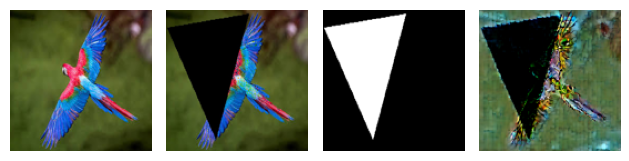

In [57]:
pred_img = prompt_to_img(orig_img_latent, 
                         masked_img_latent, 
                         mask_latent, 
                         text_embeddings,
                         attempt_key = "Attempt4G",
                         orig_img   = orig_img_ip,
                         masked_img = masked_img_ip,
                         mask       = mask_ip ,
                         _prompt    = prompt_ip, 
                         num_inference_steps = 50, 
                         return_all_latents=False, seed=42)[-1]

show_images(orig_img_resize, masked_img_resize, mask_img_resize, pred_img)

###Attempt4H

Attempt : [{'infer_steps': 30, 'noise_reduce_item': 'MI', 'noise_pred_item': 'OI-MI-BM'}]
Infer steps : tensor([999, 979, 959, 939, 919, 899, 879, 859, 839, 819, 799, 779, 759, 739,
        719, 699, 679, 659, 639, 619, 599, 579, 559, 539, 519, 500, 480, 460,
        440, 420])


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

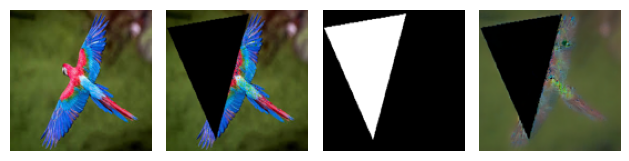

In [58]:
pred_img = prompt_to_img(orig_img_latent, 
                         masked_img_latent, 
                         mask_latent, 
                         text_embeddings,
                         attempt_key = "Attempt4H",
                         orig_img   = orig_img_ip,
                         masked_img = masked_img_ip,
                         mask       = mask_ip ,
                         _prompt    = prompt_ip, 
                         num_inference_steps = 50, 
                         return_all_latents=False, seed=42)[-1]

show_images(orig_img_resize, masked_img_resize, mask_img_resize, pred_img)

###Attempt4I

Attempt : [{'infer_steps': 10, 'noise_reduce_item': 'MI', 'noise_pred_item': 'OI-MI-BM'}]
Infer steps : tensor([999, 979, 959, 939, 919, 899, 879, 859, 839, 819])


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

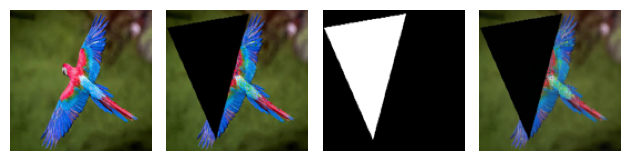

In [59]:
pred_img = prompt_to_img(orig_img_latent, 
                         masked_img_latent, 
                         mask_latent, 
                         text_embeddings,
                         attempt_key = "Attempt4I",
                         orig_img   = orig_img_ip,
                         masked_img = masked_img_ip,
                         mask       = mask_ip ,
                         _prompt    = prompt_ip, 
                         num_inference_steps = 50, 
                         return_all_latents=False, seed=42)[-1]

show_images(orig_img_resize, masked_img_resize, mask_img_resize, pred_img)

###Attempt4J

Attempt : [{'infer_steps': 50, 'noise_reduce_item': 'OI', 'noise_pred_item': 'OI-MI-BM'}]
Infer steps : tensor([999, 979, 959, 939, 919, 899, 879, 859, 839, 819, 799, 779, 759, 739,
        719, 699, 679, 659, 639, 619, 599, 579, 559, 539, 519, 500, 480, 460,
        440, 420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180,
        160, 140, 120, 100,  80,  60,  40,  20])


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

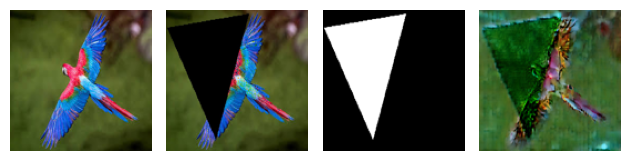

In [60]:
pred_img = prompt_to_img(orig_img_latent, 
                         masked_img_latent, 
                         mask_latent, 
                         text_embeddings,
                         attempt_key = "Attempt4J",
                         orig_img   = orig_img_ip,
                         masked_img = masked_img_ip,
                         mask       = mask_ip ,
                         _prompt    = prompt_ip, 
                         num_inference_steps = 50, 
                         return_all_latents=False, seed=42)[-1]

show_images(orig_img_resize, masked_img_resize, mask_img_resize, pred_img)

###Attempt4K

Attempt : [{'infer_steps': 30, 'noise_reduce_item': 'OI', 'noise_pred_item': 'OI-MI-BM'}]
Infer steps : tensor([999, 979, 959, 939, 919, 899, 879, 859, 839, 819, 799, 779, 759, 739,
        719, 699, 679, 659, 639, 619, 599, 579, 559, 539, 519, 500, 480, 460,
        440, 420])


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

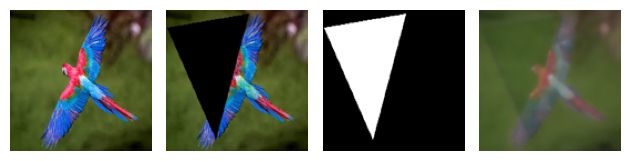

In [61]:
pred_img = prompt_to_img(orig_img_latent, 
                         masked_img_latent, 
                         mask_latent, 
                         text_embeddings,
                         attempt_key = "Attempt4K",
                         orig_img   = orig_img_ip,
                         masked_img = masked_img_ip,
                         mask       = mask_ip ,
                         _prompt    = prompt_ip, 
                         num_inference_steps = 50, 
                         return_all_latents=False, seed=42)[-1]

show_images(orig_img_resize, masked_img_resize, mask_img_resize, pred_img)

###Attempt4L

Attempt : [{'infer_steps': 10, 'noise_reduce_item': 'OI', 'noise_pred_item': 'OI-MI-BM'}]
Infer steps : tensor([999, 979, 959, 939, 919, 899, 879, 859, 839, 819])


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

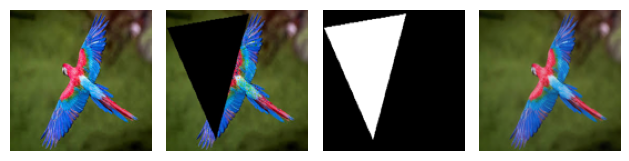

In [62]:
pred_img = prompt_to_img(orig_img_latent, 
                         masked_img_latent, 
                         mask_latent, 
                         text_embeddings,
                         attempt_key = "Attempt4L",
                         orig_img   = orig_img_ip,
                         masked_img = masked_img_ip,
                         mask       = mask_ip ,
                         _prompt    = prompt_ip, 
                         num_inference_steps = 50, 
                         return_all_latents=False, seed=42)[-1]

show_images(orig_img_resize, masked_img_resize, mask_img_resize, pred_img)